In [26]:
pwd = "/Users/youtao/code"
hdf5_data_path = '/scratch/ty296/hdf5_data/'
groupname = 'L'
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.4
import os
print(os.getcwd())
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
import h5py
import numpy as np

/Users/youtao/code/CT_MPS_mini


In [27]:
# View singular values from your HDF5 file
filename = os.path.join(pwd, "hdf5_data_combined/sv_combined_p_ctrl0.0.h5")
print(filename)
real_num = 0
with h5py.File(filename, 'r') as f:
    # Get the first key to examine
    first_key = list(f.keys())[real_num]
    print(f"Examining key: {first_key}")
    
    # Get the singular values array
    sv_array = f[first_key][()]
    
    # Display basic info
    print(f"Shape: {sv_array.shape}")
    print(f"Data type: {sv_array.dtype}")
    print(f"Number of singular values: {len(sv_array)}")
    
    # Display the actual values
    print(f"\nSingular values:")
    print(sv_array)
    
    # Display metadata
    print(f"\nMetadata:")
    for attr_name, attr_value in f[first_key].attrs.items():
        print(f"  {attr_name}: {attr_value}")


/Users/youtao/code/hdf5_data_combined/sv_combined_p_ctrl0.0.h5
Examining key: real1
Shape: (1024,)
Data type: float64
Number of singular values: 1024

Singular values:
[6.23137332e-02 6.16276907e-02 6.14375849e-02 ... 1.48454760e-04
 1.22651931e-04 1.84403662e-05]

Metadata:
  L: 20
  maxbond: 1024
  maxdim: 1024
  n_chunk_realizations: 10
  p_ctrl: 0.0
  p_proj: 0.0
  seed: 8216


In [28]:
with h5py.File(filename, 'r') as f:
    L_target = 24
    matching_groups = []
    
    print(f"Searching for groups with L={L_target}...")
    print("=" * 80)
    
    # Loop through all realizations
    for key in f.keys():
        # Check if this group has L=24
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            matching_groups.append(key)
    
    print(f"Found {len(matching_groups)} groups with L={L_target}")
    print()
    
    # # Display information for each matching group
    # for i, key in enumerate(matching_groups):
    #     sv_array = f[key][()]
    #     attrs = dict(f[key].attrs)
        
    #     print(f"Group {i+1}: {key}")
    #     print(f"  L = {attrs.get('L')}")
    #     print(f"  p_ctrl = {attrs.get('p_ctrl')}")
    #     print(f"  p_proj = {attrs.get('p_proj')}")
    #     print(f"  maxbond = {attrs.get('maxbond')}")
    #     print(f"  Singular value array shape: {sv_array.shape}")
    #     print(f"  Singular values: {sv_array}")
    #     print(f"  Max SV: {np.max(sv_array):.6e}")
    #     print(f"  Min SV: {np.min(sv_array):.6e}")
    #     print(f"  Number of SVs: {len(sv_array)}")
    #     print("-" * 60)


Searching for groups with L=24...
Found 44061 groups with L=24



In [29]:
# Plot singular values for all L=24 groups
L24_groups = []

with h5py.File(filename, 'r') as f:
    L_target = 24
    
    # Collect all L=24 groups
    for key in f.keys():
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            L24_groups.append(key)


In [30]:
dict_min_sv = {}
for key in L24_groups[:]:
    with h5py.File(filename, 'r') as f:
        # print(f[key].attrs.keys())
        min_sv = min(f[key][()])
        # print(f[key].attrs.keys())
        p_proj = f[key].attrs['p_proj']
        seed = f[key].attrs['seed']
        if p_proj in dict_min_sv:
            dict_min_sv[p_proj].append((np.log10(min_sv), seed))
        else:
            dict_min_sv[p_proj] = [(np.log10(min_sv), seed)]
        # if min_sv < 1e-10:
        #     print(min_sv, p_proj)

        # print(min_sv.shape)


In [31]:
for min_sv, seed in dict_min_sv[0.2]:
    if min_sv < -10:
        print(min_sv, seed)


-16.133717651192967 8891
-16.226160717513487 2294
-16.1593281633254 7970
-16.15177860479611 3771
-16.19995772702894 3831
-16.267176307459234 5471
-16.13694467850258 755
-16.302954528125806 8192
-16.084078043432 1412
-16.10046104468901 8423
-16.19176672665553 4523
-16.194098682529187 2069
-16.12932298424592 1743
-16.079555274846737 1412
-16.074366330007486 1553
-16.154982233098384 3688
-16.152005330272317 1388
-16.05048850806191 1634
-16.176323603877254 1529
-16.141324046695626 9410
-10.317505009603655 836
-16.174648715832653 4925
-16.180669134044326 6083
-16.101682844662474 8822
-16.148982506574978 8760
-16.16945380145926 2786
-16.24640969908465 7605
-16.085555567022173 1035
-16.28389140912643 4598
-16.10340124120973 8294
-16.13694467850258 755
-16.7934265059486 7037
-16.11624914544463 5798
-16.035871448764745 9068
-16.15745582704651 2955
-16.219455036600703 8532
-16.157037056055877 9899
-16.10390724535385 830
-16.09705741851286 8487
-16.16415492780362 8074
-16.00454725584474 3985
-16.

81 0.0


/var/folders/kg/tvbzq59s75x2mgxmldyjkcjw0000gn/T/ipykernel_2835/4098502039.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


3986 0.2
1994 0.24210526
2000 0.24210526315789474
2000 0.28421052631578947
2000 0.3263157894736842
2000 0.3684210526315789
2000 0.4105263157894737
2000 0.45263157894736844
2000 0.49473684210526314
2000 0.5368421052631579
2000 0.5789473684210527
2000 0.6210526315789474
2000 0.6631578947368421
2000 0.7052631578947368
2000 0.7473684210526316
2000 0.7894736842105263
2000 0.8315789473684211
2000 0.8736842105263158
2000 0.9157894736842105
2000 0.9578947368421052
2000 1.0


/var/folders/kg/tvbzq59s75x2mgxmldyjkcjw0000gn/T/ipykernel_2835/4098502039.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/youtao/miniconda3/envs/scicomp/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


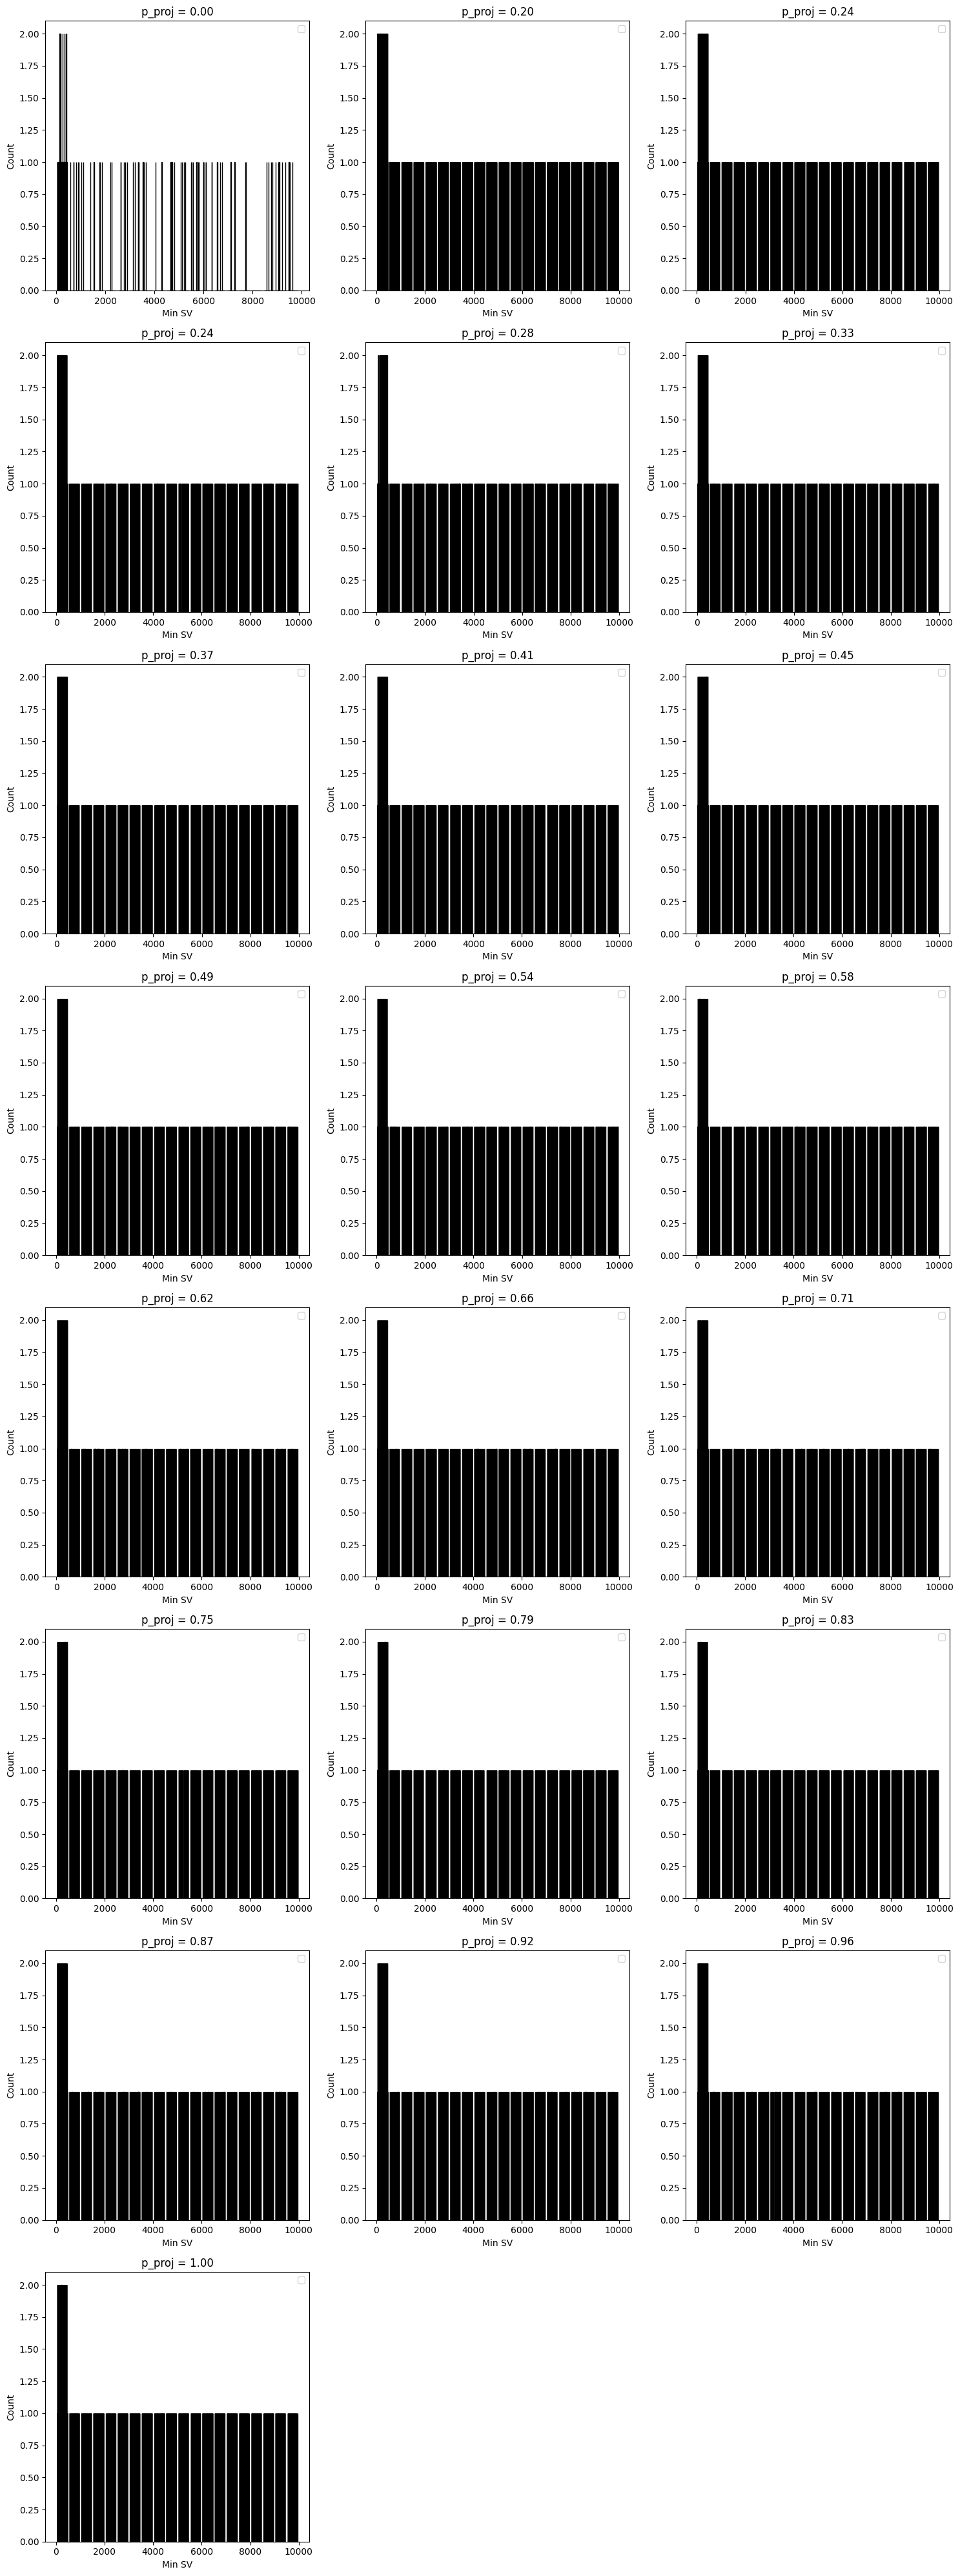

In [32]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict_min_sv)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, min_svs) in enumerate(sorted(dict_min_sv.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(min_svs)
    var, semvar = calculate_variance_and_error(min_svs)
    print(len(min_svs), p_proj)
    ax.hist(min_svs, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Min SV')
    ax.set_ylabel('Count')
    # ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    # ax.axvline(mean + var, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    # ax.axvline(mean - var, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict_min_sv), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [33]:
from read_hdf5_func import von_neumann_entropy_sv
dict = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        entropy = von_neumann_entropy_sv(f[key][()], n=0, positivedefinite=False, threshold=1e-15)
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict:
            dict[p_proj].append(entropy)
        else:
            dict[p_proj] = [entropy]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

In [34]:
print(len(dict))

22


81 0.0
3986 0.2
1994 0.24210526
2000 0.24210526315789474
2000 0.28421052631578947
2000 0.3263157894736842
2000 0.3684210526315789
2000 0.4105263157894737
2000 0.45263157894736844
2000 0.49473684210526314
2000 0.5368421052631579
2000 0.5789473684210527
2000 0.6210526315789474
2000 0.6631578947368421
2000 0.7052631578947368
2000 0.7473684210526316
2000 0.7894736842105263
2000 0.8315789473684211
2000 0.8736842105263158
2000 0.9157894736842105
2000 0.9578947368421052
2000 1.0


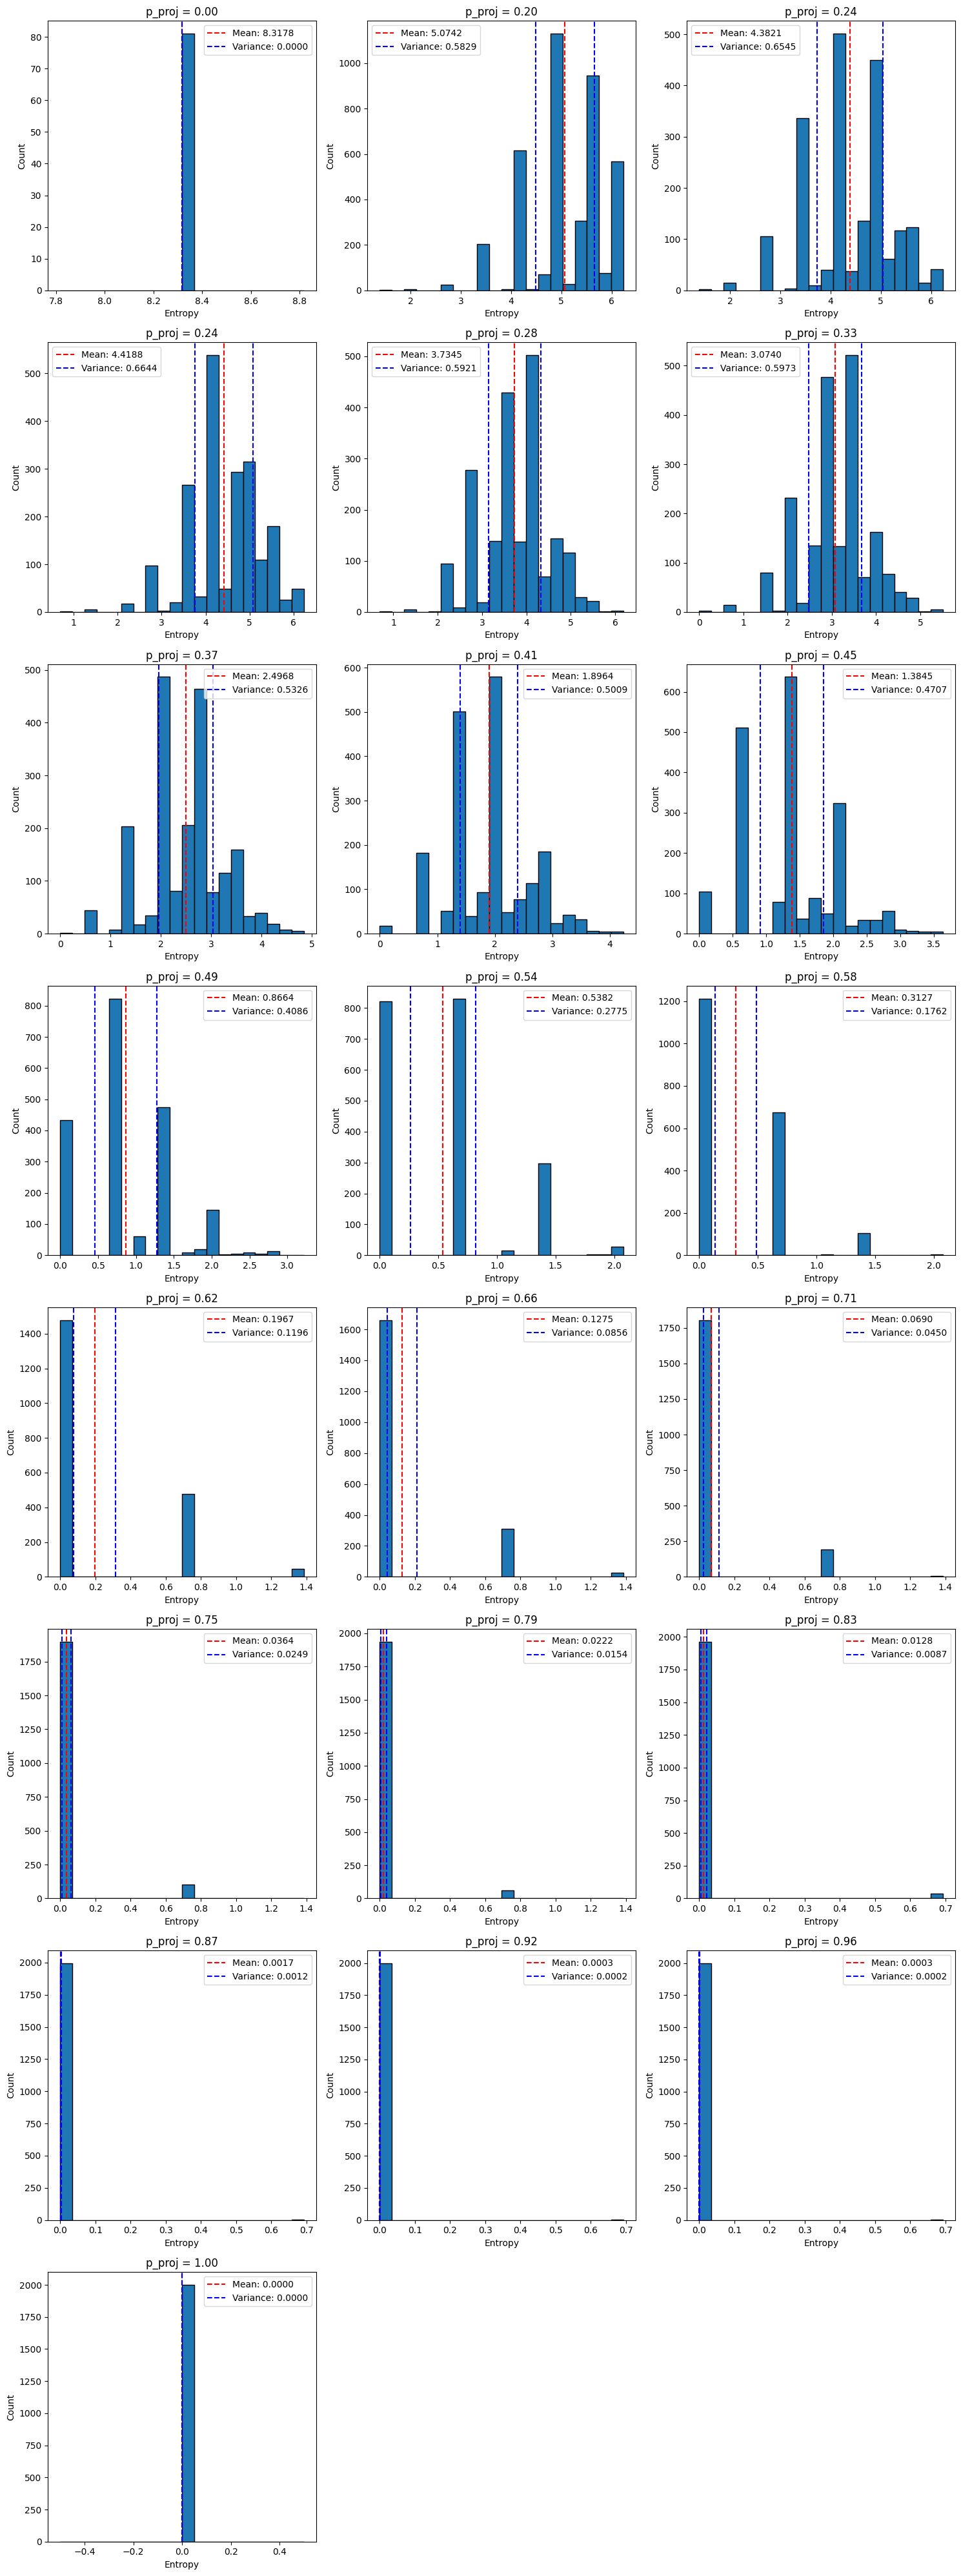

In [35]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, entropies) in enumerate(sorted(dict.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(entropies)
    var, semvar = calculate_variance_and_error(entropies)
    print(len(entropies), p_proj)
    ax.hist(entropies, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + var, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - var, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [36]:
dict_maxbond = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        maxbond = f[key].attrs['maxbond']
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict_maxbond:
            dict_maxbond[p_proj].append(maxbond)
        else:
            dict_maxbond[p_proj] = [maxbond]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

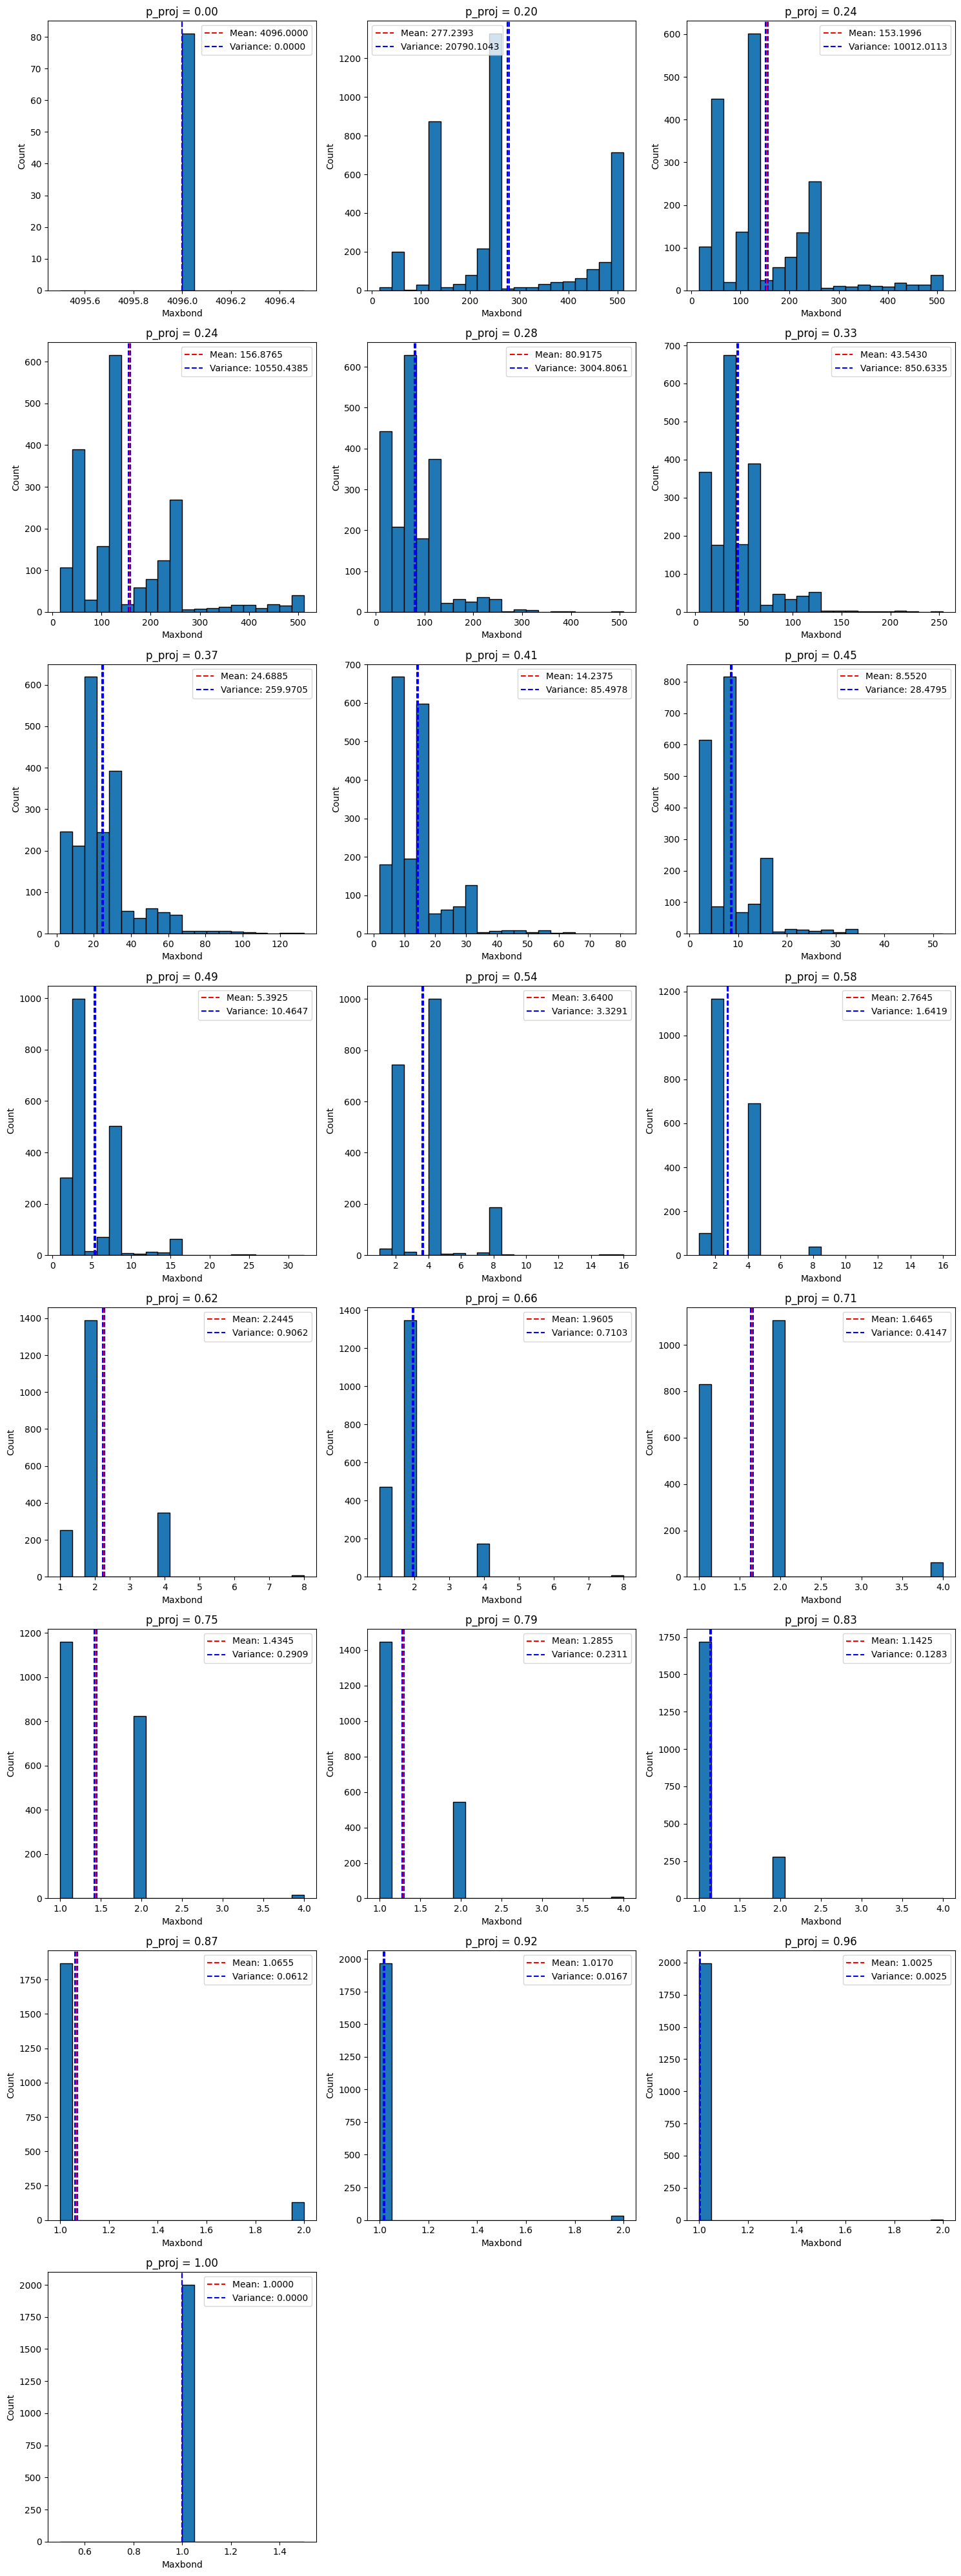

In [37]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict_maxbond)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, maxbonds) in enumerate(sorted(dict_maxbond.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(maxbonds)
    var, semvar = calculate_variance_and_error(maxbonds)
    # print(maxbonds)
    ax.hist(maxbonds, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Maxbond')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + sem, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - sem, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [38]:
print(list(dict_maxbond.keys()))
key = list(dict_maxbond.keys())

print(key)
print(dict_maxbond[key])

[0.0, 0.24210526, 1.0, 0.6210526315789474, 0.5789473684210527, 0.9578947368421052, 0.5368421052631579, 0.49473684210526314, 0.45263157894736844, 0.4105263157894737, 0.3684210526315789, 0.3263157894736842, 0.28421052631578947, 0.24210526315789474, 0.2, 0.9157894736842105, 0.8736842105263158, 0.8315789473684211, 0.7894736842105263, 0.7473684210526316, 0.7052631578947368, 0.6631578947368421]
[0.0, 0.24210526, 1.0, 0.6210526315789474, 0.5789473684210527, 0.9578947368421052, 0.5368421052631579, 0.49473684210526314, 0.45263157894736844, 0.4105263157894737, 0.3684210526315789, 0.3263157894736842, 0.28421052631578947, 0.24210526315789474, 0.2, 0.9157894736842105, 0.8736842105263158, 0.8315789473684211, 0.7894736842105263, 0.7473684210526316, 0.7052631578947368, 0.6631578947368421]


TypeError: unhashable type: 'list'

In [ ]:
len(L24_groups)

: 

: 

: 

: 

: 

: 

: 

: 